# Import Packages

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import struct
import numpy as np

# Custom Dataset Class

In [8]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        """
        Custom Dataset for MNIST using uncompressed .ubyte files.

        Args:
            images_path (str): Path to the images .ubyte file.
            labels_path (str): Path to the labels .ubyte file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = self._load_images(images_path)
        self.labels = self._load_labels(labels_path)
        self.transform = transform

    def _load_images(self, filepath):
        with open(filepath, 'rb') as f:
            # Read magic number, number of images, rows, and columns
            magic, num, rows, cols = struct.unpack(">IIII", f.read(16))

            # Verify the expected size (60,000 images x 784 pixels)
            expected_size = num * rows * cols
            data = np.frombuffer(f.read(), dtype=np.uint8)

            # Ensure data is of expected size (60000 * 784 for training images)
            if data.size != expected_size:
                raise ValueError(f"Expected {expected_size} bytes, but got {data.size}.")

            # Reshape the data into (num_images, 1, 28, 28)
            data = data.reshape(num, rows, cols)

        return torch.tensor(data, dtype=torch.float32) / 255.0  # Normalize to [0, 1]

    def _load_labels(self, filepath):
        with open(filepath, 'rb') as f:
            # Read magic number, number of labels
            magic, num = struct.unpack(">II", f.read(8))
            # Read label data
            data = np.frombuffer(f.read(), dtype=np.uint8)

        return torch.tensor(data, dtype=torch.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


# Data Preparation

In [9]:
# Transform for data normalization
transform = transforms.Compose([transforms.Lambda(lambda x: x.unsqueeze(0)), transforms.Normalize((0.5,), (0.5,))])

# Paths to MNIST .gz files
train_images_path = "train-images-idx3-ubyte"
train_labels_path = "train-labels-idx1-ubyte"
test_images_path = "t10k-images-idx3-ubyte"
test_labels_path = "t10k-labels-idx1-ubyte"

# Create Dataset instances
training_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)
test_dataset = MNISTDataset(test_images_path, test_labels_path, transform=transform)
print("training dataset size: ", len(training_dataset))
print("test dataset size: ", len(test_dataset))

# Splitting Dataset into Training and Validation Sets
val_size = len(training_dataset) // 6  # 1/6 for validation
train_size = len(training_dataset) - val_size

train_dataset, val_dataset = random_split(training_dataset, [train_size, val_size])

print("Training dataset size after splitting:", len(train_dataset))
print("Validation dataset size after splitting:", len(val_dataset))
print("Testing dataset size remains unchanged:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

training dataset size:  60000
test dataset size:  10000
Training dataset size after splitting: 50000
Validation dataset size after splitting: 10000
Testing dataset size remains unchanged: 10000


# CNN Architecture

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.norm1 = nn.LayerNorm([32, 28, 28])
        self.norm2 = nn.LayerNorm([64, 14, 14])
        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.norm1(torch.relu(self.conv1(x))))
        x = self.pool(self.norm2(torch.relu(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Training Function

In [11]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Plotting

In [12]:
def plot_metrics(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Testing

In [13]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total = 0  # Total number of samples
    correct = 0  # Number of correctly classified samples
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation during testing
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the class with the highest score
            total += labels.size(0)  # Increment total samples
            correct += (preds == labels).sum().item()  # Count correct predictions
            all_preds.extend(preds.cpu().numpy())  # Save predictions
            all_labels.extend(labels.cpu().numpy())  # Save true labels

    # Calculate accuracy
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

# Running the code

Epoch 1/10, Train Loss: 0.2692, Val Loss: 0.0834
Epoch 2/10, Train Loss: 0.0898, Val Loss: 0.0613
Epoch 3/10, Train Loss: 0.0674, Val Loss: 0.0508
Epoch 4/10, Train Loss: 0.0553, Val Loss: 0.0451
Epoch 5/10, Train Loss: 0.0450, Val Loss: 0.0435
Epoch 6/10, Train Loss: 0.0375, Val Loss: 0.0397
Epoch 7/10, Train Loss: 0.0333, Val Loss: 0.0410
Epoch 8/10, Train Loss: 0.0288, Val Loss: 0.0365
Epoch 9/10, Train Loss: 0.0257, Val Loss: 0.0420
Epoch 10/10, Train Loss: 0.0234, Val Loss: 0.0335


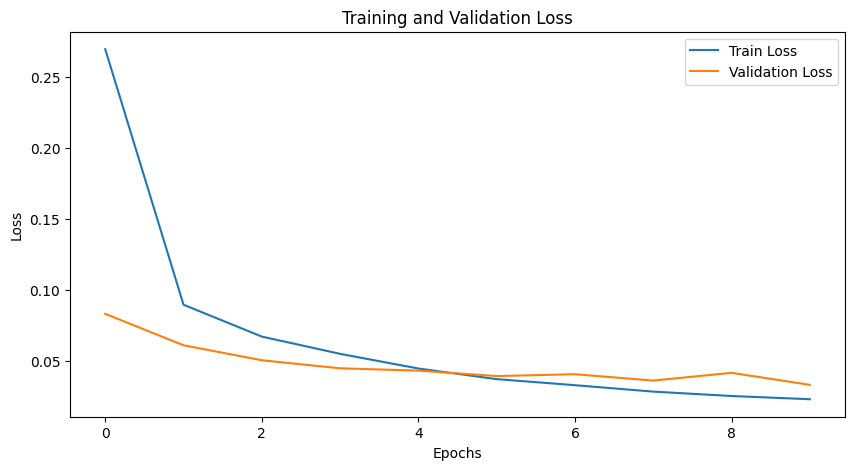

Test Accuracy: 99.19%


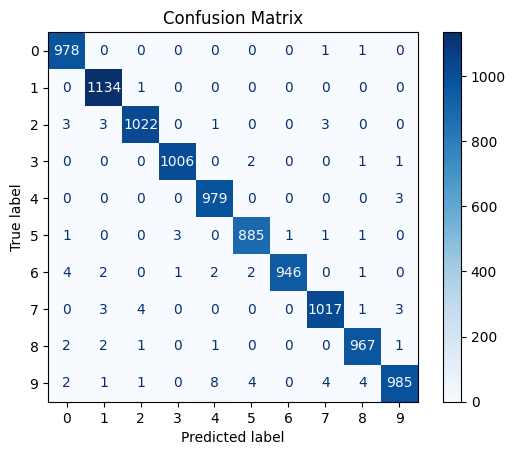

In [14]:
model = CNN()
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=10, lr=0.01)
plot_metrics(train_losses, val_losses)
test_model(model, test_loader)